# Simulating outcomes from College Nationals 10,000 times

The goal is to evaluate which combination of 2 mens teams, 2 womens teams, and one 
bonus team (either division) will produce the most points, based on the following 
scoring system:


## Scoring:


- For each win in pool play and the bracket, you will receive points equal to the team’s seed within their pool.
- Winning your pool is worth one bonus point.
- Quarterfinal wins are worth one bonus point.
- Semifinal wins are worth two bonus points.
- Winning the championship is worth three bonus points.

Example: You select the Texas women, the third seed in Pool D. They go 2-2 in pool play, win their 
prequarter and quarterfinal, and lose in semifinals. They would earn 6 points for pool play (2 wins 
worth 3 points each), and 6 points for their two bracket wins (2 wins worth 3 points each), with one bonus point for winning a quarterfinal, totaling 13 points.

## Format:
20 teams in 4 pools of five teams:

### Womens Pools:
![title](WomensPools.png)

### Mens Pools:
![title](MensPools.png)

### Bracket:
![title](WomensBracket.png)



Daniel Walton 5/16/2019

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import re
import math
import collections
from numpy.random import binomial
%matplotlib inline

In [2]:
# Low res figures for now
%matplotlib inline

In [12]:
# Get some good colors for plotting
cmap = cm.get_cmap('Set1')
num_colors = 9
colors = {}
for i in range(num_colors):
    colors[i] = cmap((i+0.5)/num_colors)

In [3]:
# Handy way for storing scores
Score = collections.namedtuple('Score', ['team_a', 'team_b'])

In [4]:
# Format for game logs
GameLog = collections.namedtuple('GameLog', ['level','name','team_a_name','team_b_name','score','winner','loser',\
                                             'child_a','child_b','parent'])

In [5]:
# Test for GameLog type
log_semis = GameLog(level='S', name='Semis1', team_a_name='North Carolina', team_b_name='Washington', \
                    score=Score(team_a=15, team_b=12), winner='North Carolina', loser='Washington', \
                   child_a=None, child_b=None, parent=None)
print(log_semis)
print(type(log_semis))

GameLog(level='S', name='Semis1', team_a_name='North Carolina', team_b_name='Washington', score=Score(team_a=15, team_b=12), winner='North Carolina', loser='Washington', child_a=None, child_b=None, parent=None)
<class '__main__.GameLog'>


In [462]:
# Abbreviation for Rounds('levels')
level_dict = {'PP':'Pool Play', 'P':'Prequarter', 'Q':'Quarter', 'S':'Semifinal', 'F':'Final', 'W':'Winner'}

In [506]:
# Scoring for 'TheGame'
get_pool_play_points = lambda seed, pool_play_wins, rank: seed*pool_play_wins + int(rank==1) 

bracket_bonus = {'PP':0, 'P':0, 'Q':1, 'S':2, 'F':3, 'W':0} # Champion has no-one left to bead
accumulated_bracket_bonus = {'PP':0, 'P':0, 'Q':1, 'S':3, 'F':6, 'W':6} # cumulative sum of bracket_bonus

get_bracket_play_points = lambda seed, bracket_play_wins, highest_game_won: seed*bracket_play_wins + \
                                                                       accumulated_bracket_bonus[highest_game_won]

get_total_points = lambda seed, pool_play_wins, rank, bracket_play_wins, highest_game_won: \
                    get_pool_play_points(seed, pool_play_wins, rank) + \
                    get_bracket_play_points(seed, bracket_play_wins, highest_game_won)

In [466]:
# Testing scoring
get_total_points(5,0,5,0,'PP')

0

In [13]:
# Get USAU Ratings
#
# Read in FullTeamRankings saved from USAU Ultimate Rankings Page 5/16/2019
# link: https://play.usaultimate.org/teams/events/team_rankings/?RankSet=College-Women
#
# Couldn't get all teams directly, so just clicked show all and then saved as .html locally.

womens_ranking_html = r'FullTeamRankings_women.html'
mens_ranking_html   = r'FullTeamRankings_men.html'

# Use pandas html reader to extract dataframe
result = pd.read_html(womens_ranking_html)
df_women = result[0]

result = pd.read_html(mens_ranking_html)
df_men = result[0]

# Last row contains garbage, so remove it.
df_women = df_women.drop(index=len(df_women)-1)
df_men   = df_men.drop(index=len(df_men)-1)

# Convert numeric columns to from string/object to correct type
cols = ['Rank', 'Power Rating', 'Wins', 'Losses']
df_women[cols] = df_women[cols].apply(pd.to_numeric)
df_men[cols] = df_men[cols].apply(pd.to_numeric)

In [17]:
# Get Nationals pools
#
# womens url = r'http://collegechampionships.usaultimate.org/d1-women/schedule-results/'
# mens url   = r'http://collegechampionships.usaultimate.org/d1-men/schedule-results/' 
#
def get_pools(pools_dict):
    """
    Determine the pools based on a pools dictionary that looks like this:
    
    {'A':'North Carolina (1) Ohio State (8) Georgia (12) Minnesota (13) California (17)',
     'B':'Brown (2) North Carolina State (7) Texas (11) Michigan (14) Iowa State (18)',
     'C':'Pittsburgh (3) Oregon (6) Wisconsin (10) Tufts (15) Victoria (19)',
     'D':'Cal Poly-SLO (4) Colorado (5) Washington (9) Northeastern (16) Rutgers (20)'}
    
    Returns a dictionary with the same keys, but the values are now tuples with the team names (no seeds) in order.
    """
    
    for pool, string in pools_dict.items():
        # Initial Split
        string_split = re.split(' \([0-9]+\)', string) 

        # Clean up leading spaces and final entry
        del string_split[-1]
        string_split = [item[1:] if item[0]==' ' else item for i, item in enumerate(string_split)]

        # Create tuple
        pools_dict[pool] = tuple(string_split)
    return pools_dict


# Get women's and men's pools
womens_pools = get_pools({'A':'North Carolina (1) Pittsburgh (8) UCLA (12) Colorado (13) Oregon (17)',
                 'B':'Ohio State (2) California-Santa Barbara (7) Northeastern (11) Minnesota (14) Washington (18)',
                 'C':'California-San Diego (3) Western Washington (6) Georgia (10) Tufts (15) Northwestern (19)',
                 'D':'Carleton College-Syzygy (4) Dartmouth (5) Texas (9) Wisconsin (16) Cornell (20)'})

mens_pools = get_pools({'A':'North Carolina (1) Ohio State (8) Georgia (12) Minnesota (13) California (17)',
                 'B':'Brown (2) North Carolina State (7) Texas (11) Michigan (14) Iowa State (18)',
                 'C':'Pittsburgh (3) Oregon (6) Wisconsin (10) Tufts (15) Victoria (19)',
                 'D':'Cal Poly-SLO (4) Colorado (5) Washington (9) Northeastern (16) Rutgers (20)'})

# Get number of teams per pool
teams_per_pool = len(womens_pools['A'])
print('# teams per pool: '+str(teams_per_pool)+'\n')

# Print pools
print(womens_pools)
print('\n',mens_pools)

# teams per pool: 5

{'A': ('North Carolina', 'Pittsburgh', 'UCLA', 'Colorado', 'Oregon'), 'B': ('Ohio State', 'California-Santa Barbara', 'Northeastern', 'Minnesota', 'Washington'), 'C': ('California-San Diego', 'Western Washington', 'Georgia', 'Tufts', 'Northwestern'), 'D': ('Carleton College-Syzygy', 'Dartmouth', 'Texas', 'Wisconsin', 'Cornell')}

 {'A': ('North Carolina', 'Ohio State', 'Georgia', 'Minnesota', 'California'), 'B': ('Brown', 'North Carolina State', 'Texas', 'Michigan', 'Iowa State'), 'C': ('Pittsburgh', 'Oregon', 'Wisconsin', 'Tufts', 'Victoria'), 'D': ('Cal Poly-SLO', 'Colorado', 'Washington', 'Northeastern', 'Rutgers')}


In [18]:
def get_list_teams_from_pools(pools):
    """
    Lists all teams in the tournament.
    
    Takes a pools dict (must be format {'A': ('Name1', ..., 'NameN'), ..., 'C':('Name1',...,'NameN')})
    and unpacks it into a list of teams.
    
    Returns list of teams in that division.
    """
    
    teams = []
    for key, item in pools.items():
        teams.extend(list(item))
        
    return teams

In [22]:
# Get lists of teams at Nationals in women's and men's division
womens_teams = get_list_teams_from_pools(womens_pools)
mens_teams = get_list_teams_from_pools(mens_pools)

print('Women\'s Teams: ')
print(womens_teams)
print('\nMen\'s Teams: ')
print(mens_teams)

Women's Teams: 
['North Carolina', 'Pittsburgh', 'UCLA', 'Colorado', 'Oregon', 'Ohio State', 'California-Santa Barbara', 'Northeastern', 'Minnesota', 'Washington', 'California-San Diego', 'Western Washington', 'Georgia', 'Tufts', 'Northwestern', 'Carleton College-Syzygy', 'Dartmouth', 'Texas', 'Wisconsin', 'Cornell']

Men's Teams: 
['North Carolina', 'Ohio State', 'Georgia', 'Minnesota', 'California', 'Brown', 'North Carolina State', 'Texas', 'Michigan', 'Iowa State', 'Pittsburgh', 'Oregon', 'Wisconsin', 'Tufts', 'Victoria', 'Cal Poly-SLO', 'Colorado', 'Washington', 'Northeastern', 'Rutgers']


In [705]:
# Give each team a color
womens_colors = ['skyblue', 'darkkhaki', 'cornflowerblue', 'gold', \
                 'darkgreen', 'silver', 'darkorange', 'crimson', 'black', \
                 'mediumpurple', 'midnightblue', 'dimgray', 'red', \
                 'darkblue', 'deepskyblue', 'rebeccapurple', 'mediumseagreen',\
                 'chocolate', 'limegreen', 'salmon']

mens_colors = ['black', 'silver', 'red', 'dimgray', 'navy', 'sienna', 'maroon', \
               'orange', 'mediumblue', 'lightcoral', 'darkkhaki', 'green', \
               'lightskyblue', 'deepskyblue', 'royalblue', 'lime', \
               'gold', 'rebeccapurple', 'black', 'crimson']

womens_team_colors = dict(zip(womens_teams, womens_colors))
mens_team_colors = dict(zip(mens_teams, mens_colors))

In [24]:
def get_df_of_team_power_ratings(teams, df_full):
    """
    Gets a dataframe with ratings of nationals teams.
    
    Takes as input the desired teams and a data frame with the full set of ratings of all teams in the
    division, then extracts the ratings for the list of teams considered.
    
    Returns a data frame with Power Rating of desired teams.
    """
    
    # Deal with Carleton College-Syzygy vs Carleton College
    if 'Carleton College' in teams:
        teams.append('Carleton College-Syzygy')
        teams.remove('Carleton College')
    
    return df_full.loc[df_full['Team'].isin(teams)][['Team','Power Rating']].set_index('Team')

In [25]:
# Get ratings of men's and women's nationals-bound teams
womens_team_ratings = get_df_of_team_power_ratings(womens_teams, df_women)
mens_team_ratings   = get_df_of_team_power_ratings(mens_teams, df_men)

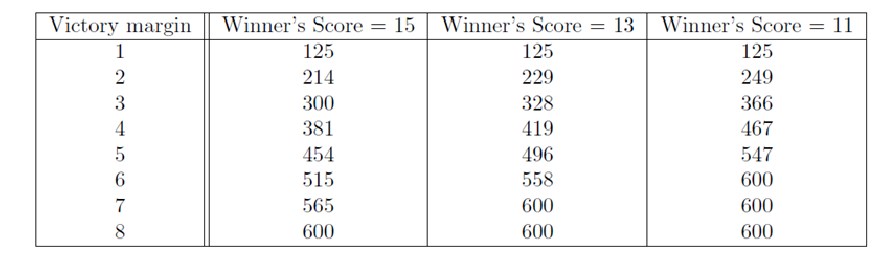

In [26]:
# Table that translates score differential to victory margin
image = plt.imread('RankingAlgorithmTable.png')
plt.figure(figsize=(15,5))
plt.imshow(image)
plt.axis('off');

In [27]:
def get_poly_function_rating_diff_to_victory_margin(rating_diff, victory_margin, game_to=15, poly_degree=3):
    """ 
    Create function to convert from points diff to victory margin.
    
    Takes as input an array of rating_diff and victory_margin.  Then fits a poly_dgree degree polynomial.
    
    Returns a function applies the polynomial but caps the victory margin at game_to.  (Because, you can't 
    win by 20 if the game is to 15, no matter how much better you are.)
    """
    
    # Fit a third degree polynomial
    coefs = np.polyfit(rating_diff, victory_margin, poly_degree)
    poly = np.poly1d(coefs)

    # Cap margin between 0 and game_to
    poly_with_cap = lambda x: np.maximum(np.minimum(poly(x), game_to),0) 
    
    return poly_with_cap

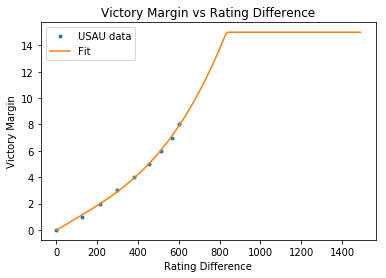

In [28]:
# Test for rating_diff_to_victory_margin

# Start with USAU algorithm data 
# (Assume winner gets 15 points)
victory_margin = np.array([0, 1,   2,   3,   4,   5,   6,   7,   8])
rating_diff =    np.array([0, 125, 214, 300, 381, 454, 515, 565, 600])

game_to = 15

# Fit function
rating_diff_to_victory_margin = get_poly_function_rating_diff_to_victory_margin(rating_diff, victory_margin, \
                                                                                game_to=game_to)

# Plot results
rating_diff_full = np.arange(0,1500,10)

plt.figure()
plt.plot(rating_diff, victory_margin, linestyle='none', marker = '.', label='USAU data')
plt.plot(rating_diff_full, rating_diff_to_victory_margin(rating_diff_full), label='Fit')
plt.xlabel('Rating Difference')
plt.ylabel('Victory Margin')
plt.title('Victory Margin vs Rating Difference')
plt.legend()
plt.show()

In [29]:
def convert_ratings_to_expected_game_score(team_a_rating, team_b_rating, game_to):
    """
    Take USAU Power Ratings of two teams and get expected game_score
    """
    if team_a_rating >= team_b_rating:
        team_a_score = game_to
        team_b_score = team_a_score - rating_diff_to_victory_margin(team_a_rating-team_b_rating)
    else:
        team_b_score = game_to
        team_a_score = team_b_score - rating_diff_to_victory_margin(team_b_rating-team_a_rating)
    score = Score(team_a=team_a_score, team_b=team_b_score)
    return score

In [30]:
def simulate_binomial_game(game_to, p):
    """
    Simulate a binomial game to game_to with a probability of success p.
    
    Game ends when either team's score reaches game_to.
    
    Returns a Score tuple of the scores.
    """
    
    team_a_score, team_b_score = 0, 0
    
    game_is_going = True
    
    while game_is_going:
        if np.random.rand() < p:
            team_a_score += 1
        else:
            team_b_score += 1
        game_is_going = (team_a_score < game_to) and (team_b_score < game_to)
    
    return Score(team_a=team_a_score, team_b=team_b_score)

In [31]:
def simulate_double_negative_binomial_game(game_to, p_a_offense, p_b_offense):
    """
    Simulate a game by flipping a coin with p_heads = p_a_offense until heads (heads->Team A, tails->Team B).
    Then, flip a coin with p_heads = p_b_offense until heads (heads->Team B, tails->Team A).
    
    Game ends when either team's score reaches game_to.
    
    Returns a Score tuple of the scores.
    """
    
    # Determine starting team
    team_a_on_offense = np.random.rand() < 0.5
    
    # Game starts 0-0
    team_a_score, team_b_score = 0, 0
    
    # Start game
    game_is_going = True
    
    
    while game_is_going:
        if team_a_on_offense:
            if np.random.rand() < p_a_offense:
                team_a_score += 1
                team_a_on_offense = False
            else:
                team_b_score += 1
        else:
            if np.random.rand() < p_b_offense:
                team_b_score += 1
                team_a_on_offense = True
            else:
                team_a_score += 1
        game_is_going = (team_a_score < game_to) and (team_b_score < game_to)
    return Score(team_a=team_a_score, team_b=team_b_score)

In [32]:
# Test for double negative binomial process

P_WINNER_SCORE_TEST = 0.8
GAME_TO_TEST = 15
RANDOM_SEED_TEST = 42
NUM_GAMES_TEST = 20
SCORE1_TEST = 15
SCORE2_TEST = 10

np.random.seed(RANDOM_SEED_TEST)
team_a_expected_score = SCORE1_TEST
team_b_expected_score = SCORE2_TEST
print(f'Expected {team_a_expected_score}-{team_b_expected_score}')
for _ in range(NUM_GAMES_TEST):
    print(simulate_double_negative_binomial_game(GAME_TO_TEST, P_WINNER_SCORE_TEST, \
                                                 P_WINNER_SCORE_TEST*(team_b_expected_score/team_a_expected_score)))

np.random.seed(RANDOM_SEED_TEST )
team_a_expected_score = SCORE2_TEST
team_b_expected_score = SCORE1_TEST
print(f'\nExpected {team_a_expected_score}-{team_b_expected_score}')
for _ in range(NUM_GAMES_TEST):
    print(simulate_double_negative_binomial_game(GAME_TO_TEST, \
                                                 P_WINNER_SCORE_TEST*(team_a_expected_score/team_b_expected_score), \
                                                 P_WINNER_SCORE_TEST))

Expected 15-10
Score(team_a=15, team_b=13)
Score(team_a=15, team_b=8)
Score(team_a=15, team_b=7)
Score(team_a=15, team_b=9)
Score(team_a=15, team_b=7)
Score(team_a=15, team_b=12)
Score(team_a=15, team_b=9)
Score(team_a=15, team_b=8)
Score(team_a=15, team_b=4)
Score(team_a=15, team_b=13)
Score(team_a=15, team_b=4)
Score(team_a=15, team_b=6)
Score(team_a=15, team_b=8)
Score(team_a=15, team_b=8)
Score(team_a=15, team_b=9)
Score(team_a=15, team_b=9)
Score(team_a=12, team_b=15)
Score(team_a=15, team_b=10)
Score(team_a=15, team_b=7)
Score(team_a=15, team_b=9)

Expected 10-15
Score(team_a=12, team_b=15)
Score(team_a=8, team_b=15)
Score(team_a=8, team_b=15)
Score(team_a=5, team_b=15)
Score(team_a=8, team_b=15)
Score(team_a=15, team_b=11)
Score(team_a=11, team_b=15)
Score(team_a=9, team_b=15)
Score(team_a=6, team_b=15)
Score(team_a=12, team_b=15)
Score(team_a=6, team_b=15)
Score(team_a=9, team_b=15)
Score(team_a=7, team_b=15)
Score(team_a=10, team_b=15)
Score(team_a=12, team_b=15)
Score(team_a=

In [33]:
def simulate_game_outcome(team_a_rating, team_b_rating, method='double negative binomial', game_to=15, \
                          p_winner_offense=0.8):
    """
    Simulate the outcome of single game played between team A and team B. 
    The result should be based on the teams' ratings.
    
    This function returns True if team A wins and False if team B wins, and the score.
    
    """
    
    # Team A always wins
    if method=='team_a': 
        team_a_score = game_to
        team_b_score = np.max([0,team_a_score-2])
    
    # Team B always wins
    elif method=='team_b': # Team A wins
        team_b_score = game_to
        team_a_score = np.max([0,team_b_score-2])
    
    # Higher rating always wins
    elif method=='higher_rating': # Team A wins
        if team_a_rating > team_b_rating:
            team_a_score = game_to
            team_b_score = np.max([0,team_a_score-2])
        else:
            team_a_score = game_to
            team_b_score = np.max([0,team_a_score-2])
    
    # Random coin flip
    elif method=='random': 
        if random.random()>0.5:
            team_a_score = game_to
            team_b_score = np.max([0,team_a_score-2])
        else:
            team_a_score = game_to
            team_b_score = np.max([0,team_a_score-2])
    
    # 'binomial': Simulate game as first to achieve 15 successes of a weighted coin flip.
    #
    # Assume if game is expected to finish Team A 15-8 Team B, then the probability of Team A
    # winning a particular point is p = 15 / (15 + 8).
    # Then, a new full game can be simulated as a sequence of Bernoulli trials with probability with p
    # that terminates when either the number of success or failures reaches game_to.
    elif method=='binomial': # Use ratings
        expected_score = convert_ratings_to_expected_game_score(team_a_rating, team_b_rating, game_to)
        
        p = expected_score.team_a*1.0 / (expected_score.team_a + expected_score.team_b) # Prob A wins a given point
        
        actual_score_this_time = simulate_binomial_game(game_to, p)
        team_a_score = actual_score_this_time.team_a
        team_b_score = actual_score_this_time.team_b
        
    
    
#     'double negative binomial': Simulate game as using two weighted coins (one for each team's offense).  
    
#     Randomly decide which team starts on offense.  Say team A goes first, flip their weighted coin with 
#     probability P_a_offense until a heads is seen.  Record 1 point for Team A and the number of tails seen
#     as points for Team B.  Then it's B's turn to be on offense.  Flip the weighted coin with probability P_b_offense
#     until a heads seen.  Record a 1 point from Team B and the number of tails seen as points for Team A.
#     Repeat until one team has 15 points.
    
#     Assumes there are two distinct fixed probabilities: 
#      -  P_a_offense = the prob A scores a point when on offense
#      -  P_b_offense = the prob B score a point when on offense
    
#     We don't know a priori what the relationship is between P_a_offense and P_b_offense.  And we only have one
#     input currently: the expected game score (e.g. 15-8).  So we have two unknowns and one piece of information.
#     So, we make the simplifying assumption (based on data from Ultianalytics.com) that for elite mens college 
#     teams, the winning team typically has a P_a_offense = 0.8.  Then, to get an expected result 15-8, we need
#     P_b_offense = P_a_offense * 8/15. 
    
#     Note: P_a_offense = 0.8 is an important assumption.  If it were greater, scores would have less variance.
#     If it were less, scores would have more variance.  Thus, if it's a cross wind, then P_a_offense would likely be 
#     closer to 0.5.  Meanwhile, in perfect conditions, one would expect P_a_offense to be slightly higher.
    
    elif method=='double negative binomial': 
        # Convert ratings to expected score
        expected_score = convert_ratings_to_expected_game_score(team_a_rating, team_b_rating, game_to)
        
        # Assign expected winner's probability of scoring an O-point to be p_winner_offense (usually 0.8)
        if expected_score.team_a > expected_score.team_b:
            p_a_offense = p_winner_offense
            p_b_offense = p_a_offense * expected_score.team_b/(1.0*game_to)
        else:
            p_b_offense = p_winner_offense
            p_a_offense = p_b_offense * expected_score.team_a/(1.0*game_to)

        # Simulate double binomial
        actual_score_this_time = simulate_double_negative_binomial_game(game_to, p_a_offense=p_a_offense, \
                                                                        p_b_offense=p_b_offense)
        team_a_score = actual_score_this_time.team_a
        team_b_score = actual_score_this_time.team_b
        
    
    # Method not recognized
    else:
        raise ValueError('method not recognized')
        team_a_score = -1
        team_b_score = -2
    
    # Record score in named Tuple
    score = Score(team_a=team_a_score, team_b=team_b_score)
    
    # Team A wins if they have more points
    team_a_wins = score.team_a > score.team_b
    
    return team_a_wins, score

In [34]:
# Test simulate_game_outcome
np.random.seed(42)
num_games_test = 10000

method = 'double negative binomial'
game_to = 15

team_a = 'North Carolina'

team_a_rating = mens_team_ratings.loc[team_a]['Power Rating']
rating_diff_values = np.arange(0,1000,10)
team_a_win_perc = np.zeros(rating_diff_values.shape)

team_a_score_counters = collections.defaultdict(collections.Counter)
team_b_score_counters = collections.defaultdict(collections.Counter)

for i, rating_diff in enumerate(rating_diff_values):
    team_b_rating = team_a_rating - rating_diff
    
    num_team_a_wins = 0
    num_team_b_wins = 0
    
    for _ in range(num_games_test):
        team_a_wins, score = simulate_game_outcome(team_a_rating, team_b_rating, method=method, game_to=game_to)
        
        # Tally wins
        if team_a_wins:
            num_team_a_wins += 1 
        else: 
            num_team_b_wins += 1 
    
        team_a_score_counters[rating_diff][score.team_a] += 1
        team_b_score_counters[rating_diff][score.team_b] += 1
    
    team_a_win_percentage_here = num_team_a_wins/num_games_test
    team_a_win_perc[i] = team_a_win_percentage_here

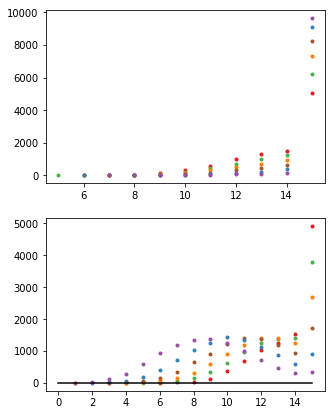

In [39]:
# Plot distributions
plt.figure(figsize=(5,7))
plt.subplot(2,1,1)
for diff in range(0,600,100):
    for team_a_score, count in team_a_score_counters[diff].items():
        plt.plot(team_a_score, count, '.', color=colors[int(np.mod(diff,7))])
plt.subplot(2,1,2)
for diff in range(0,600,100):
    for team_b_score, count in team_b_score_counters[diff].items():
        plt.plot(team_b_score, count, '.', color=colors[int(np.mod(diff,7))])
plt.plot([0, 15], [0, 0], 'k')
#plt.ylim([0, num_games_test])
plt.show()

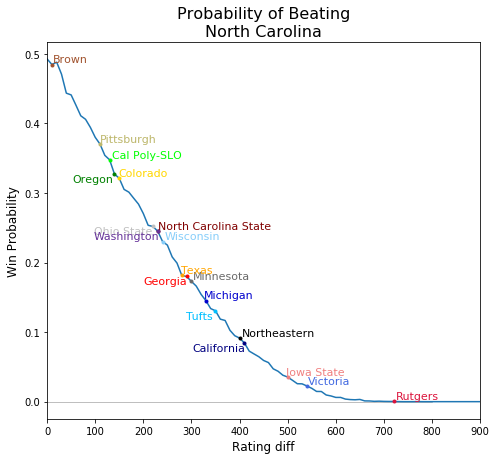

In [288]:
# North Carolina Test Case
division = 'Men\'s'
fig = plt.figure(figsize=(7, 6.5))
fig.patch.set_facecolor('white')
plt.plot([0, 800], [0, 0], color='gray', linestyle='-', linewidth=0.5)
plt.plot(rating_diff_values, 1-team_a_win_perc)
flip_teams = ['Washington','California', 'Oregon', 'Georgia', 'Tufts', 'Ohio State']
ignore_teams = [team_a]
for team in mens_teams:
    if team not in ignore_teams:
        team_rating_here = mens_team_ratings.loc[team]['Power Rating']
        index_min_rating_diff = np.argmin(abs(rating_diff_values-(team_a_rating-team_rating_here)))
        team_a_win_perc_here = team_a_win_perc[index_min_rating_diff]
        #plt.plot([team_a_rating - team_rating_here, team_a_rating - team_rating_here], [0.0, 1.0], color=mens_team_colors[team])
        plt.plot(rating_diff_values[index_min_rating_diff], 1-team_a_win_perc_here, color=mens_team_colors[team], \
                 linestyle='none', marker='.')
        text_here = team + ' (self)' if team==team_a else team
        FONTSIZE = 11
        if team in flip_teams:
            plt.text(team_a_rating-team_rating_here, 1-team_a_win_perc_here, text_here, color=mens_team_colors[team], \
                     rotation=-0, verticalalignment='top', horizontalalignment='right',fontsize=FONTSIZE)
        else:
            plt.text(team_a_rating-team_rating_here, 1-team_a_win_perc_here, text_here, color=mens_team_colors[team], \
                     rotation=-0, verticalalignment='bottom', horizontalalignment='left',fontsize=FONTSIZE)
#plt.ylim([0.0, 1.0])
plt.xlim([-0, 900])
#plt.yticks(np.arange(0.0,1.2,.2))
plt.ylabel(f'Win Probability', fontsize = 12)
plt.xlabel(f'Rating diff', fontsize = 12)
#plt.title(f'Probabilty of Beating\n{team_a}\n(n = {num_games_test})', fontsize = 16)
plt.title(f'Probability of Beating\n{team_a}', fontsize = 16)
plt.tight_layout()
plt.show()

In [514]:
# Game class - used for simulating bracket game
class Game:
    def __init__(self, level=None, name='', team_a_name=None, team_b_name=None, \
                 parent=None, child_a=None, child_b=None, \
                 team_a_score=0, team_b_score=0, winner_name=None, winner_rating=None, \
                 loser_name=None, loser_rating=None, played=False, \
                 team_a_rating=None, team_b_rating=None, game_to=15, \
                 log=None, method='double negative binomial'):
        self.level=level
        self.name = name
        self.parent = parent
        self.played = False
        self.team_a_name = team_a_name
        self.team_b_name = team_b_name
        self.parent = parent
        self.child_a = child_a
        self.child_b = child_b
        self.team_a_score = team_a_score
        self.team_b_score = team_b_score
        self.winner_name = winner_name
        self.winner_rating = winner_rating
        self.loser_name = loser_name
        self.loser_rating = loser_rating
        self.team_a_rating = team_a_rating
        self.team_b_rating = team_b_rating
        self.game_to = game_to
        self.method = method
        self.score = None
        self.team_a_wins = None
        self.log = log
        
    def set_team_a_wins():
        if self.played:
            return self.team_a_score > self.team_b_score
        else:
            raise Exception('Game has not been played!')
    
    def set_winner(self):
        if self.played:
            if self.team_a_wins:
                self.winner_name = self.team_a_name
                self.winner_rating = self.team_a_rating
                self.loser_name = self.team_b_name
                self.loser_rating = self.team_b_rating
                self.winner_score = self.team_a_score
                self.loser_score = self.team_b_score
            else:
                self.winner_name = self.team_b_name
                self.winner_rating = self.team_b_rating
                self.loser_name = self.team_a_name
                self.loser_rating = self.team_a_rating
                self.winner_score = self.team_b_score
                self.loser_score = self.team_a_score
        else:
            raise Exception('Games has not been played!')
    
    def play_game(self):
        if self.played:
            raise Exception('Game already played!')
        if self.team_a_rating and self.team_b_rating:
            self.team_a_wins, score = simulate_game_outcome(self.team_a_rating, self.team_b_rating, \
                                                            method=self.method, game_to=self.game_to)
            self.score = score
            self.team_a_score, self.team_b_score = score.team_a, score.team_b
            self.played = True
            self.set_winner()
        else:
            raise Exception('Need team_a_rating and team_b_rating to be not None!')
    
    def log_score(self):
        game = GameLog(level=self.level, name=self.name, \
                team_a_name=self.team_a_name, team_b_name=self.team_b_name, \
                score=self.score, winner=self.winner_name, loser=self.loser_name, \
                child_a=(self.child_a.name if self.child_a else None), \
                child_b=(self.child_b.name if self.child_b else None), \
                parent=(self.parent.name if self.parent else None))
        try:
            self.log.append(game)
        except:
            self.log = [game]
    
    def extend_log(self, other_log):
        try:
            self.log.extend(other_log)
        except:
            self.log = other_log
    
    def play_children_and_self(self):
        if self.child_a:
            self.child_a.parent = self
            if not self.child_a.played:
                self.child_a.play_children_and_self()
            self.team_a_name = self.child_a.winner_name
            self.team_a_rating = self.child_a.winner_rating
            self.extend_log(self.child_a.log)
        if self.child_b:
            self.child_b.parent = self
            if not self.child_b.played:
                self.child_b.play_children_and_self()
            self.team_b_name = self.child_b.winner_name
            self.team_b_rating = self.child_b.winner_rating
            self.extend_log(self.child_b.log)
        if not self.played:
            self.play_game()
            self.log_score()
            #print(self.name + ': ' + self.winner_name + ' beats ' + self.loser_name+f' {self.winner_score}-{self.loser_score}!')

In [515]:
# Tests for Game class
quarterfinal = Game(level='Q', name='Quarterfinal 1', team_a_name='Colorado', team_a_rating=1800)
quarterfinal.team_b_name, quarterfinal.team_b_rating = 'Washington', 1750
print(quarterfinal.team_b_rating)

semifinal = Game(level='S', name='Semifinal 1', team_a_name='North Carolina', team_a_rating=2100, child_b=quarterfinal)
print(semifinal.team_a_rating)
print(semifinal.played)

np.random.seed(37)
semifinal.play_children_and_self()

print('Quarterfinal:')
print(quarterfinal.score)
print(quarterfinal.winner_name)
print(quarterfinal.team_a_score)
print(quarterfinal.team_b_score)
print(quarterfinal.played)
print(quarterfinal.team_a_wins)
print('\nSemifinal:')
print(semifinal.team_a_name)
print(semifinal.team_b_name)
print(semifinal.team_a_score)
print(semifinal.team_b_score)
print(semifinal.score)
print(semifinal.winner_name)
print(semifinal.played)
print(semifinal.team_a_wins)
print('')
print('Log:')
print(semifinal.log)

1750
2100
False
Quarterfinal:
Score(team_a=15, team_b=10)
Colorado
15
10
True
True

Semifinal:
North Carolina
Colorado
12
15
Score(team_a=12, team_b=15)
Colorado
True
False

Log:
[GameLog(level='Q', name='Quarterfinal 1', team_a_name='Colorado', team_b_name='Washington', score=Score(team_a=15, team_b=10), winner='Colorado', loser='Washington', child_a=None, child_b=None, parent='Semifinal 1'), GameLog(level='S', name='Semifinal 1', team_a_name='North Carolina', team_b_name='Colorado', score=Score(team_a=12, team_b=15), winner='Colorado', loser='North Carolina', child_a=None, child_b='Quarterfinal 1', parent=None)]


In [951]:
def simulate_pool_play(pools, ratings, max_rank_make_bracket=3):
    """
    
    Simulate Pool Play
    
    Here are the rules for breaking ties:
    http://www.usaultimate.org/assets/1/AssetManager/Format%20Manual%20Version%204.3%20_7.1.08__updated%208.25.10_.pdf
    
    
    """
    
    win_loss_matrix_list = [] # record wins
    score_matrix_list = [] # record scores
    
    pool_play_outcomes_dict = {} # record pool play outcomes
    
    # Play all games
    for pool, teams in pools.items():
        num_teams = len(teams)
        teams_list = list(teams)
        team_wins = collections.defaultdict(int)
        team_index = {team:i for i,team in enumerate(teams_list)}
        team_rvindex = {i:team for i,team in enumerate(teams_list)}
        
        win_loss_matrix = np.zeros([num_teams,num_teams]) # For recording wins
        score_matrix = np.zeros([num_teams,num_teams]) # For recording scores
        
        max_loops = 10
        loops = 0
        while teams_list and loops < max_loops:
            team_A = teams_list.pop()
            
            for team_B in teams_list:
                
                # Simulate the game
                team_a_wins, score = simulate_game_outcome(ratings.loc[team_A].values[0], \
                                                           ratings.loc[team_B].values[0], method='double negative binomial')
                #print(team_A, ratings.loc[team_A].values[0], team_B, ratings.loc[team_B].values[0], team_a_wins)
                
                # Log the wins
                win_loss_matrix[team_index[team_A],team_index[team_B]] = int(team_a_wins)
                win_loss_matrix[team_index[team_B],team_index[team_A]] = int(not team_a_wins)
                
                # Log the score
                score_matrix[team_index[team_A],team_index[team_B]] = score.team_a
                score_matrix[team_index[team_B],team_index[team_A]] = score.team_b
                
            loops += 1
        
        win_loss_matrix_list.append(win_loss_matrix)
        score_matrix_list.append(score_matrix)
    
        # Create data frame to store pool play outcomes
        pool_play_outcomes = pd.DataFrame(list(teams), columns=['Team'])
    
        # Count Wins and Losses
        wins   = [sum(win_loss_matrix[team_index[team],:]) for team in teams]
        losses = [num_teams-1-num for num in wins]
        pool_play_outcomes['Wins'] = wins
        pool_play_outcomes['Losses'] = losses
        
        
        
        # Determine Pool Finish (Rank)
        """
        WARNING: ACTUAL USAU TIE BREAKER RULES ARE NOT USED
        """
        
        # First create temporary column with points scored against teams with same number of wins
        points_scored_against_teams_with_same_wins_list = []
        for team in list(teams):
            this_teams_wins = pool_play_outcomes['Wins'].loc[team_index[team]]
            ids_of_teams_with_same_wins = list(pool_play_outcomes[pool_play_outcomes['Wins']==this_teams_wins].index.values)
            points_scored_against_teams_with_same_wins =  np.sum(score_matrix[team_index[team],\
                                                                              ids_of_teams_with_same_wins])
            points_scored_against_teams_with_same_wins_list.append(points_scored_against_teams_with_same_wins)
        pool_play_outcomes['TiebreakerPts'] = points_scored_against_teams_with_same_wins_list
        
        
        # Then create a temporary column of random numbers to break otherwise unbreakable ties
        pool_play_outcomes['TiebreakerRand'] = np.random.rand(num_teams)
        
        # Break ties
        pool_play_outcomes.sort_values(by=['Wins', 'TiebreakerPts', 'TiebreakerRand'], inplace=True, ascending=False)
        pool_play_outcomes.reset_index(inplace=True)
        pool_play_outcomes.rename(columns = {'index':'Seed'}, inplace=True) 
        
        # Get Rank and Seed 
        # (where did each team start and where did the finish in 1-based indexing)
        pool_play_outcomes['Rank'] = list(pool_play_outcomes.index.values + 1)
        pool_play_outcomes['Seed'] = pool_play_outcomes['Seed'] + 1

        # Made bracket?
        pool_play_outcomes['MadeBracket'] = pool_play_outcomes['Rank'].apply(lambda r : r <= max_rank_make_bracket)
        
        # Calculate points earned
        pool_play_outcomes['Points'] = pool_play_outcomes['Seed'] * pool_play_outcomes['Wins'] + \
                                       (pool_play_outcomes['Rank']==1).astype(int)
    
        # Add Pool to columns
        pool_play_outcomes['Pool'] = [pool]*len(pool_play_outcomes.index)
    
        # Differentiate pool play data from total data
        pool_play_outcomes['PoolPlayPoints'] = pool_play_outcomes['Points']
        pool_play_outcomes['PoolPlayWins'] = pool_play_outcomes['Wins']
        pool_play_outcomes['PoolPlayLosses'] = pool_play_outcomes['Losses']
        
        # Record highest level achieved as pool play -- for now
        pool_play_outcomes['HighLevel'] = ['PP']*len(pool_play_outcomes.index)
        
        # Reorder columns
        pool_play_outcomes = pool_play_outcomes[['Pool','Rank','Seed', 'Team', \
                                                 'PoolPlayPoints', 'PoolPlayWins', 'PoolPlayLosses',\
                                                 'Wins', 'Losses','Points', 'MadeBracket', 'HighLevel']]
    
        # Record these outcomes
        pool_play_outcomes_dict[pool] = pool_play_outcomes
    
    
    # Keep track of points earned
    return pool_play_outcomes_dict

In [915]:
def simulate_bracket_play(pool_play_results, ratings, bracket_format='12-team pool winners bye'):
    
    # Gather pool play results from each pool into single dataframe
    for pool, pool_results in pool_play_results.items():
            if pool=='A':
                tournament_results = pool_results
            else:
                tournament_results = tournament_results.append(pool_results)
    
    # Reset index
    tournament_results.reset_index(inplace=True)
    tournament_results.drop(columns=['index'], inplace=True)
    
    # Lambdas for getting seed teams and their ratings
    get_team_name = lambda pool, rank: pool_play_results[pool].loc[rank-1]['Team']
    get_team_rating = lambda pool, rank: ratings.loc[get_team_name(pool, rank)]['Power Rating']
    
    # Initialize log
    bracket_games = [] 
    
    if bracket_format=='12-team pool winners bye':
        
        # Setup bracket
        prequarters_1 = Game(level='P',name='Pre-Quarters 1', team_a_name=get_team_name('B',2), team_a_rating=get_team_rating('B',2), \
                             team_b_name=get_team_name('C',3), team_b_rating=get_team_rating('C',3))
        prequarters_2 = Game(level='P',name='Pre-Quarters 2', team_a_name=get_team_name('B',3), team_a_rating=get_team_rating('B',3), \
                          team_b_name=get_team_name('C',2), team_b_rating=get_team_rating('C',2))
        prequarters_3 = Game(level='P',name='Pre-Quarters 3', team_a_name=get_team_name('A',3), team_a_rating=get_team_rating('A',3), \
                          team_b_name=get_team_name('D',2), team_b_rating=get_team_rating('D',2))
        prequarters_4 = Game(level='P',name='Pre-Quarters 4', team_a_name=get_team_name('A',2), team_a_rating=get_team_rating('A',2), \
                          team_b_name=get_team_name('D',3), team_b_rating=get_team_rating('D',3))
        
        quarters_1 = Game(level='Q',name='Quarters 1', team_a_name=get_team_name('A',1), team_a_rating=get_team_rating('A',1), \
                          child_b=prequarters_1)
        quarters_2 = Game(level='Q',name='Quarters 2', team_a_name=get_team_name('D',1), team_a_rating=get_team_rating('D',1), \
                          child_b=prequarters_2)
        quarters_3 = Game(level='Q',name='Quarters 3', team_a_name=get_team_name('C',1), team_a_rating=get_team_rating('C',1), \
                          child_b=prequarters_3)
        quarters_4 = Game(level='Q',name='Quarters 4', team_a_name=get_team_name('B',1), team_a_rating=get_team_rating('B',1), \
                          child_b=prequarters_4)
        
        semis_1 = Game(level='S',name='Semis 1', child_a=quarters_1, child_b=quarters_2)
        semis_2 = Game(level='S',name='Semis 2', child_a=quarters_3, child_b=quarters_4)
        
        finals = Game(level='F',name='Finals',child_a=semis_1, child_b=semis_2, log=bracket_games)
        
        # Play Recursively
        finals.play_children_and_self()
        
        # Update tournament results based on logs
        for game_log in finals.log:
            
            winner_index = np.where(tournament_results['Team'] == game_log.winner)[0][0]
            loser_index = np.where(tournament_results['Team'] == game_log.loser)[0][0]
            
            tournament_results.at[winner_index, 'Wins'] = tournament_results.at[winner_index, 'Wins'] + 1
            tournament_results.at[loser_index, 'Losses'] = tournament_results.at[loser_index, 'Losses'] + 1
            tournament_results.at[winner_index, 'Points'] = tournament_results.at[winner_index, 'Points'] + \
                                                            tournament_results.at[winner_index, 'Seed'] + \
                                                            bracket_bonus[game_log.level]
                                                            
            tournament_results.at[winner_index, 'HighLevel'] = game_log.level
            tournament_results.at[loser_index, 'HighLevel'] = game_log.level
            
            # Distinguish Champion 
            if game_log.level=='F': 
                tournament_results.at[winner_index, 'HighLevel'] = 'W'
            
    else:
        raise Exception('Bracket format unknown!')
    return tournament_results

In [916]:
def simulate_tournament(pools, ratings, tourney_format='20-team nationals'):
    if tourney_format=='20-team nationals':
        # Pool play in 4 pools of 5 teams
        pool_play_results = simulate_pool_play(pools, ratings)
                
        # Bracket play 12 teams with pool winners getting bye to quarters
        tournament_results = simulate_bracket_play(pool_play_results, ratings, bracket_format='12-team pool winners bye')   
    else:
        raise Exception('The only working format right now is 20-team nationals.')
    return tournament_results

In [917]:
def simulate_multiple_tournaments(pools, ratings, num_tournaments=1, tourney_format='20-team nationals'):
    for i in range(num_tournaments):
        
        # Simulate tournament
        results = simulate_tournament(pools, ratings, tourney_format)
        
        # Add column with TournamentID
        results['TournamentID'] = [i]*len(results.index)
        
        # Put TournamentID as first column
        results = results[['TournamentID','Pool','Rank','Seed', 'Team', \
                           'PoolPlayPoints', 'PoolPlayWins', 'PoolPlayLosses',\
                           'Wins', 'Losses','Points', 'MadeBracket', 'HighLevel']]
        
        # Append results
        if i==0:
            multiple_tournament_results = results
        else:
            multiple_tournament_results = multiple_tournament_results.append(results)
        
    # Reset index
    multiple_tournament_results.reset_index(inplace=True)
    multiple_tournament_results.rename(columns={'index':'TeamID'}, inplace=True)
    return multiple_tournament_results

In [953]:
np.random.seed(0)

In [954]:
# Test simulate tournament
simulate_tournament(mens_pools, mens_team_ratings).sort_values(by=['Pool','Rank'], ascending=[True, True])

,Pool,Rank,Seed,Team,PoolPlayPoints,PoolPlayWins,PoolPlayLosses,Wins,Losses,Points,MadeBracket,HighLevel
0,A,1,1,North Carolina,5.0,4.0,0.0,7.0,0.0,14.0,True,W
1,A,2,4,Minnesota,8.0,2.0,2.0,2.0,3.0,8.0,True,P
2,A,3,3,Georgia,6.0,2.0,2.0,3.0,3.0,9.0,True,Q
3,A,4,2,Ohio State,2.0,1.0,3.0,1.0,3.0,2.0,False,PP
4,A,5,5,California,5.0,1.0,3.0,1.0,3.0,5.0,False,PP
5,B,1,3,Texas,13.0,4.0,0.0,4.0,1.0,13.0,True,Q
6,B,2,1,Brown,3.0,3.0,1.0,4.0,2.0,4.0,True,Q
7,B,3,4,Michigan,8.0,2.0,2.0,2.0,3.0,8.0,True,P
8,B,4,2,North Carolina State,2.0,1.0,3.0,1.0,3.0,2.0,False,PP
9,B,5,5,Iowa State,0.0,0.0,4.0,0.0,4.0,0.0,False,PP


In [956]:
np.random.seed(42)

In [957]:
# Test simulate multiple tournaments
simulate_multiple_tournaments(mens_pools, mens_team_ratings, \
                              num_tournaments=2).sort_values(by=['TournamentID','Pool','Rank'], ascending=True)

,TeamID,TournamentID,Pool,Rank,Seed,Team,PoolPlayPoints,PoolPlayWins,PoolPlayLosses,Wins,Losses,Points,MadeBracket,HighLevel
0,0,0,A,1,4,Minnesota,13.0,3.0,1.0,3.0,2.0,13.0,True,Q
1,1,0,A,2,3,Georgia,9.0,3.0,1.0,4.0,2.0,12.0,True,Q
2,2,0,A,3,1,North Carolina,3.0,3.0,1.0,4.0,2.0,4.0,True,Q
3,3,0,A,4,2,Ohio State,2.0,1.0,3.0,1.0,3.0,2.0,False,PP
4,4,0,A,5,5,California,0.0,0.0,4.0,0.0,4.0,0.0,False,PP
5,5,0,B,1,2,North Carolina State,7.0,3.0,1.0,6.0,1.0,19.0,True,W
6,6,0,B,2,4,Michigan,12.0,3.0,1.0,3.0,2.0,12.0,True,P
7,7,0,B,3,3,Texas,6.0,2.0,2.0,3.0,3.0,9.0,True,Q
8,8,0,B,4,1,Brown,2.0,2.0,2.0,2.0,2.0,2.0,False,PP
9,9,0,B,5,5,Iowa State,0.0,0.0,4.0,0.0,4.0,0.0,False,PP


In [958]:
# Simulate womens tournament many times
np.random.seed(42)

num_simulations = 1000

womens_tournament_results = simulate_multiple_tournaments(womens_pools, womens_team_ratings, \
                                                          num_tournaments=num_simulations)

In [959]:
# Simulate men's tournament many times
np.random.seed(42)

num_simulations = 1000

mens_tournament_results = simulate_multiple_tournaments(mens_pools, mens_team_ratings, \
                                                        num_tournaments=num_simulations)

In [960]:
# Analyze women's outcomes
womens_mean_results_grouped_by_team = womens_tournament_results.groupby('Team').agg(np.mean).sort_values(by='Points', ascending=False)
womens_mean_results_grouped_by_team

,TeamID,TournamentID,Rank,Seed,PoolPlayPoints,PoolPlayWins,PoolPlayLosses,Wins,Losses,Points,MadeBracket
Team,,,,,,,,,,,
North Carolina,0.163,499.5,1.163,1.0,4.601,3.738,0.262,5.642,0.861,9.663,0.994
Dartmouth,16.047,499.5,2.047,2.0,6.097,2.870,1.130,3.781,1.975,8.690,0.897
Texas,16.847,499.5,2.847,3.0,6.735,2.206,1.794,2.661,2.494,8.262,0.702
California-San Diego,10.357,499.5,1.357,1.0,4.241,3.536,0.464,5.165,1.236,8.124,0.993
Western Washington,11.174,499.5,2.174,2.0,5.656,2.711,1.289,3.602,2.160,8.081,0.907
Wisconsin,17.340,499.5,3.340,4.0,7.137,1.768,2.232,1.974,2.691,8.006,0.460
Ohio State,5.388,499.5,1.388,1.0,4.158,3.440,0.560,4.881,1.346,7.596,0.979
Minnesota,7.488,499.5,3.488,4.0,6.193,1.537,2.463,1.773,2.944,7.205,0.481
Tufts,12.522,499.5,3.522,4.0,6.156,1.533,2.467,1.738,2.937,7.011,0.470


In [961]:
# Analyze men's outcomes
mens_mean_results_grouped_by_team = mens_tournament_results.groupby('Team').agg(np.mean).sort_values(by='Points', ascending=False)
mens_mean_results_grouped_by_team

,TeamID,TournamentID,Rank,Seed,PoolPlayPoints,PoolPlayWins,PoolPlayLosses,Wins,Losses,Points,MadeBracket
Team,,,,,,,,,,,
Washington,16.528,499.5,2.528,3.0,7.528,2.443,1.557,3.081,2.335,9.883,0.799
Oregon,11.136,499.5,2.136,2.0,5.835,2.744,1.256,3.734,2.042,8.848,0.869
Colorado,16.121,499.5,2.121,2.0,5.952,2.805,1.195,3.700,2.006,8.602,0.879
Wisconsin,11.820,499.5,2.820,3.0,6.658,2.161,1.839,2.679,2.525,8.577,0.708
Michigan,7.359,499.5,3.359,4.0,6.811,1.687,2.313,1.959,2.819,8.055,0.513
Minnesota,2.394,499.5,3.394,4.0,6.777,1.678,2.322,1.938,2.825,7.940,0.506
Brown,5.495,499.5,1.495,1.0,3.996,3.331,0.669,4.862,1.360,7.802,0.961
North Carolina,0.472,499.5,1.472,1.0,3.991,3.324,0.676,4.817,1.375,7.702,0.965
Texas,7.053,499.5,3.053,3.0,6.012,1.971,2.029,2.372,2.653,7.437,0.633


In [962]:
def count_outcomes_from_tournaments(tournament_results, teams):
    """
    Count how frequently each outcome happens for each team.
    
    Input: A data frame of tournament results from simulate_multiple_tournaments. 
    
    Output: Dictionary with value counts Series for wins, losses, rank, and points.
    
    """
    
    # Use value_counts to count each outcome
    win_counts = {}
    loss_counts = {}
    poolplaywin_counts = {}
    poolplayloss_counts = {}
    rank_counts = {}
    poolplaypoint_counts = {}
    point_counts = {}
    highlevel_counts = {}

    for team in teams:
        win_counts[team]   = tournament_results[tournament_results['Team']==team]['Wins'].value_counts()
        loss_counts[team]  = tournament_results[tournament_results['Team']==team]['Losses'].value_counts()
        poolplaywin_counts[team]   = tournament_results[tournament_results['Team']==team]['PoolPlayWins'].value_counts()
        poolplayloss_counts[team]  = tournament_results[tournament_results['Team']==team]['PoolPlayLosses'].value_counts()
        rank_counts[team]  = tournament_results[tournament_results['Team']==team]['Rank'].value_counts()
        point_counts[team] = tournament_results[tournament_results['Team']==team]['Points'].value_counts()
        poolplaypoint_counts[team] = tournament_results[tournament_results['Team']==team]['PoolPlayPoints'].value_counts()
        highlevel_counts[team] = tournament_results[tournament_results['Team']==team]['HighLevel'].value_counts()
        
        
        # For wins and losses, add dummmy values of 0 to fill out distribution
        for i in np.arange(0.0, teams_per_pool, 1.0):
            if i not in win_counts[team].index.values:
                win_counts[team][i] = 0
        
    # Create dictionary to make output easy for user
    outcome_counts = {}
    outcome_counts['Wins'] = win_counts
    outcome_counts['Losses'] = loss_counts
    outcome_counts['PoolPlayWins'] = poolplaywin_counts
    outcome_counts['PoolPlayLosses'] = poolplayloss_counts
    outcome_counts['Rank'] = rank_counts
    outcome_counts['Points'] = point_counts
    outcome_counts['PoolPlayPoints'] = poolplaypoint_counts
    outcome_counts['HighLevel'] = highlevel_counts
    
    return outcome_counts

In [963]:
# Get outcomes counts for each division
womens_outcome_counts = count_outcomes_from_tournaments(womens_tournament_results, womens_teams)
mens_outcome_counts   = count_outcomes_from_tournaments(mens_tournament_results, mens_teams)

In [964]:
def plot_points_likelihood(teams, team_colors, outcome_counts, division='(INSERT DIVISION)'):
    
    level_order = range(0,31,1)
    x_ticks = range(0,35,5)
    
    num_tournaments = np.sum(outcome_counts['HighLevel'][teams[0]])
    
    plt.figure(figsize=(10,8))
    for team in teams:
        x, y = [], []
        point_values_here = outcome_counts['Points'][team].index.values 
        #print(point_values_here)
        for i, level in enumerate(level_order):
            levels_at_this_point_or_higher = point_values_here[point_values_here > level]
            #print(levels_at_this_point_or_higher)
            x.append(i)
            total = 0
            for lev in levels_at_this_point_or_higher:
                try:
                    total += outcome_counts['Points'][team].loc[lev]
                except:
                    total += 0
            y.append(total*1./num_tournaments)
        plt.plot(x, y, '-', color=team_colors[team], label=team, linewidth=3)
    plt.xticks(x_ticks, rotation=0)
    plt.legend(loc='upper right', ncol=2, fontsize=12)
    plt.title(f'Chance of More Than x Points in #TheGame\n({division} Division)')
    plt.ylabel('Probability')
    plt.xlabel('#TheGame Points')
    plt.tight_layout()
    plt.show()

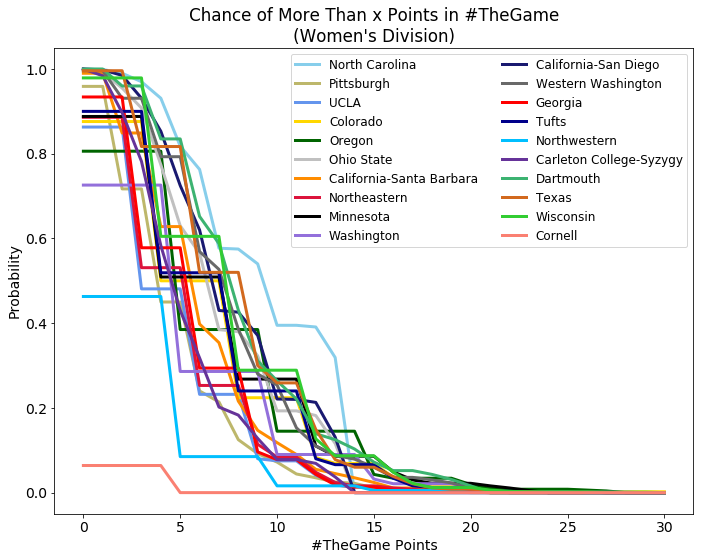

In [965]:
plot_points_likelihood(womens_teams, womens_team_colors, womens_outcome_counts, division='Women\'s')

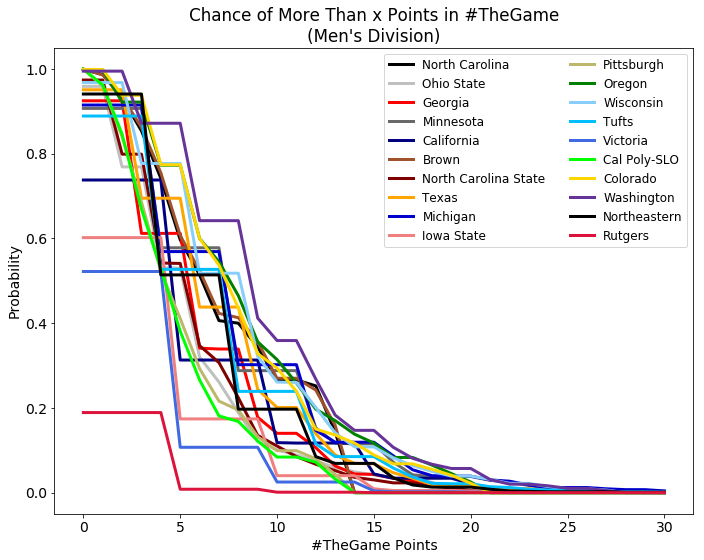

In [966]:
plot_points_likelihood(mens_teams, mens_team_colors, mens_outcome_counts, division='Men\'s')

In [1068]:
def plot_advancement_likelihood_table(teams, team_colors, outcome_counts, division='(INSERT DIVISION)'):
    
    level_order = ('P','Q','S','F','W')
    num_levels = len(level_order)
    
    num_tournaments = np.sum(outcome_counts['HighLevel'][teams[0]])
    num_teams = len(teams)
    
    advancement_matrix = np.zeros((num_teams, num_levels))
    
    fig = plt.figure(figsize=(5,4.5), dpi=300)
    fig.patch.set_facecolor('white')
    for t, team in enumerate(teams):
        for i, level in enumerate(level_order):
            levels_at_this_point_or_higher = level_order[i:]
            total = 0
            for lev in levels_at_this_point_or_higher:
                try:
                    total += outcome_counts['HighLevel'][team].loc[lev]
                except:
                    total += 0
            advancement_matrix[t,i] = np.round(total*1./num_tournaments, decimals=2)
    
    sort_by_level = ['W','F','S','Q','P']

    advancement_dataframe = pd.DataFrame(data=advancement_matrix, index=teams, columns=level_order)
    sorted_teams = list(advancement_dataframe.sort_values(by=sort_by_level).index)
    plt.pcolor(advancement_dataframe.sort_values(by=sort_by_level))
    
    for t, team in enumerate(teams):
        for i, level in enumerate(level_order):
            text_to_plot = str(np.round(advancement_dataframe.sort_values(by=sort_by_level).iloc[t,i],decimals=2))
            if float(text_to_plot) < 0.01:
                text_to_plot = '0.00'
            plt.text(i+0.5, t+.5, text_to_plot, horizontalalignment='center', \
                     verticalalignment='center', color='black', alpha=0.5, fontsize=8)
    
    plt.xticks(0.5+np.arange(0.,num_levels,1.), labels=[level_dict[level] for level in level_order], fontsize=8)
    plt.yticks(0.5+np.arange(0.,num_teams,1.), labels=sorted_teams, fontsize=8)
    plt.gca().tick_params(axis='x', bottom=False, labelbottom=False, labeltop=True)
    plt.gca().tick_params(axis='y', left=False)
    plt.title(f'{division} Division\n\n', fontsize=12)
    #cbar = plt.colorbar()
    #cbar.set_label('Probability')
    plt.tight_layout()
    plt.show()
    
    #plt.savefig(f'{division}_Advancement_Probabilities_v1.jpg', format='jpg')
    
    print(advancement_dataframe.sort_values(by=sort_by_level, ascending=False))

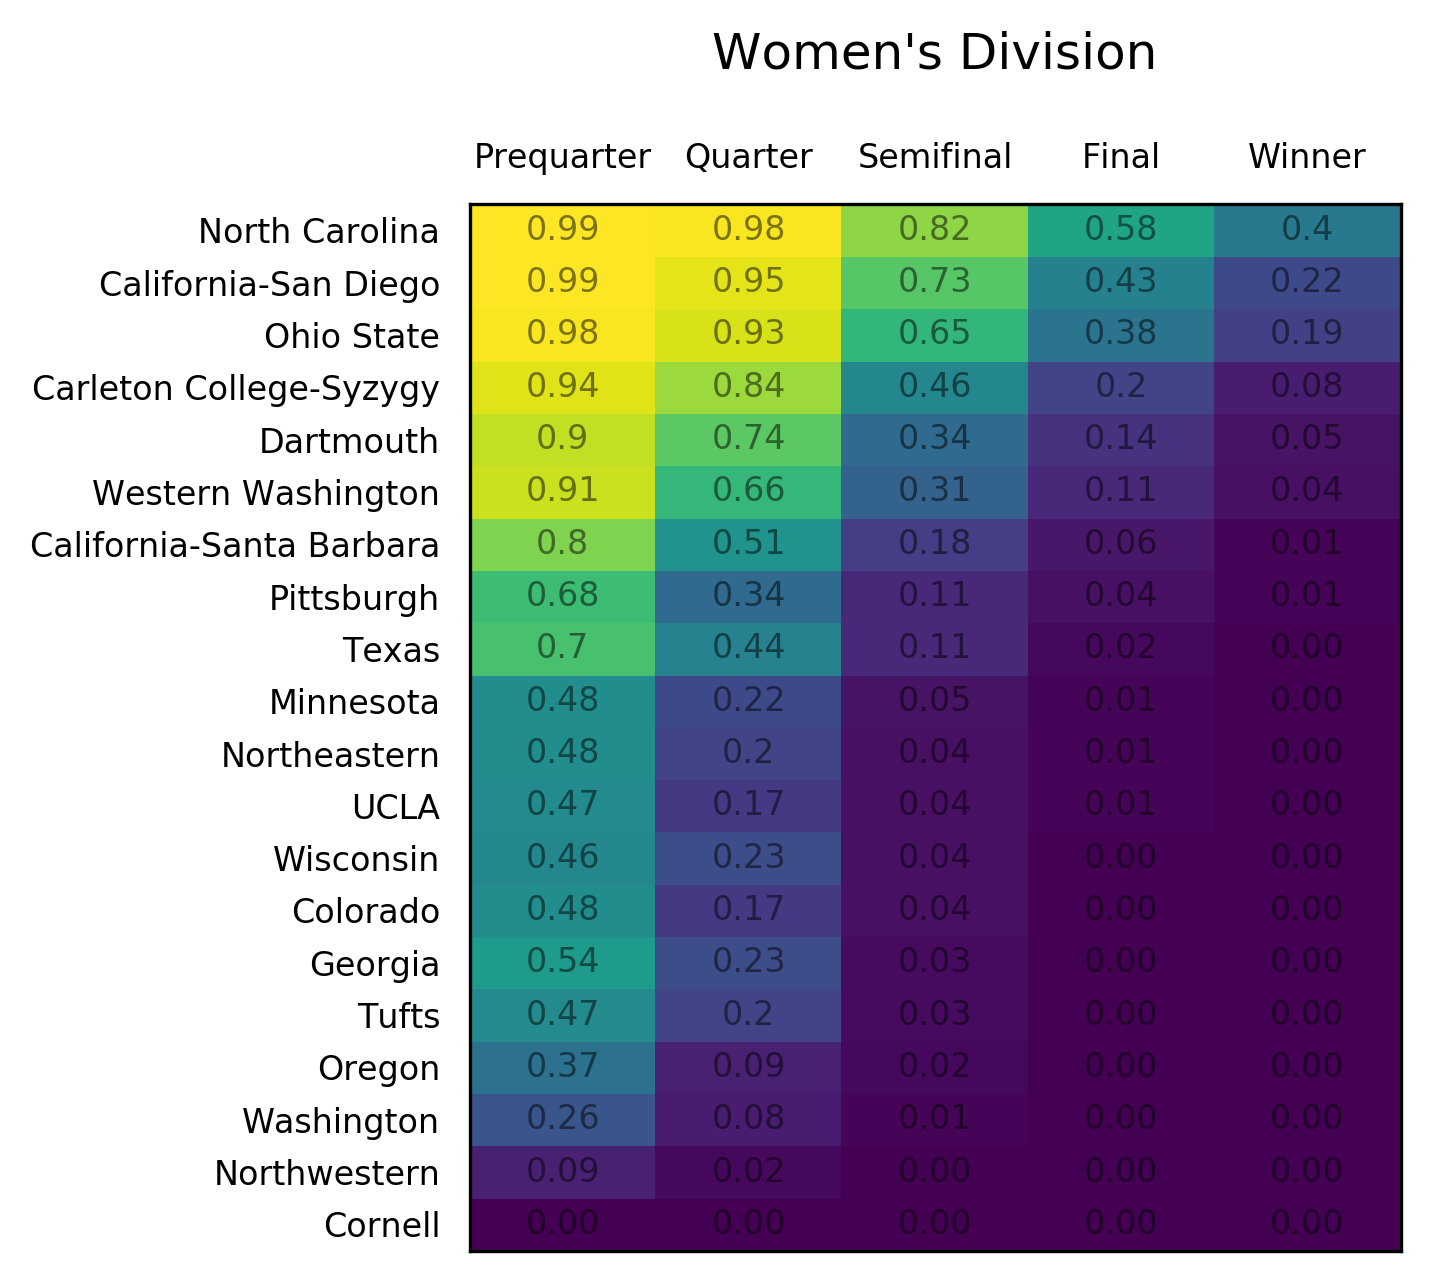

                             P     Q     S     F     W
North Carolina            0.99  0.98  0.82  0.58  0.40
California-San Diego      0.99  0.95  0.73  0.43  0.22
Ohio State                0.98  0.93  0.65  0.38  0.19
Carleton College-Syzygy   0.94  0.84  0.46  0.20  0.08
Dartmouth                 0.90  0.74  0.34  0.14  0.05
Western Washington        0.91  0.66  0.31  0.11  0.04
California-Santa Barbara  0.80  0.51  0.18  0.06  0.01
Pittsburgh                0.68  0.34  0.11  0.04  0.01
Texas                     0.70  0.44  0.11  0.02  0.00
Minnesota                 0.48  0.22  0.05  0.01  0.00
Northeastern              0.48  0.20  0.04  0.01  0.00
UCLA                      0.47  0.17  0.04  0.01  0.00
Wisconsin                 0.46  0.23  0.04  0.00  0.00
Colorado                  0.48  0.17  0.04  0.00  0.00
Georgia                   0.54  0.23  0.03  0.00  0.00
Tufts                     0.47  0.20  0.03  0.00  0.00
Oregon                    0.37  0.09  0.02  0.00  0.00
Washington

In [1069]:
plot_advancement_likelihood_table(womens_teams, womens_team_colors, womens_outcome_counts, division='Women\'s')

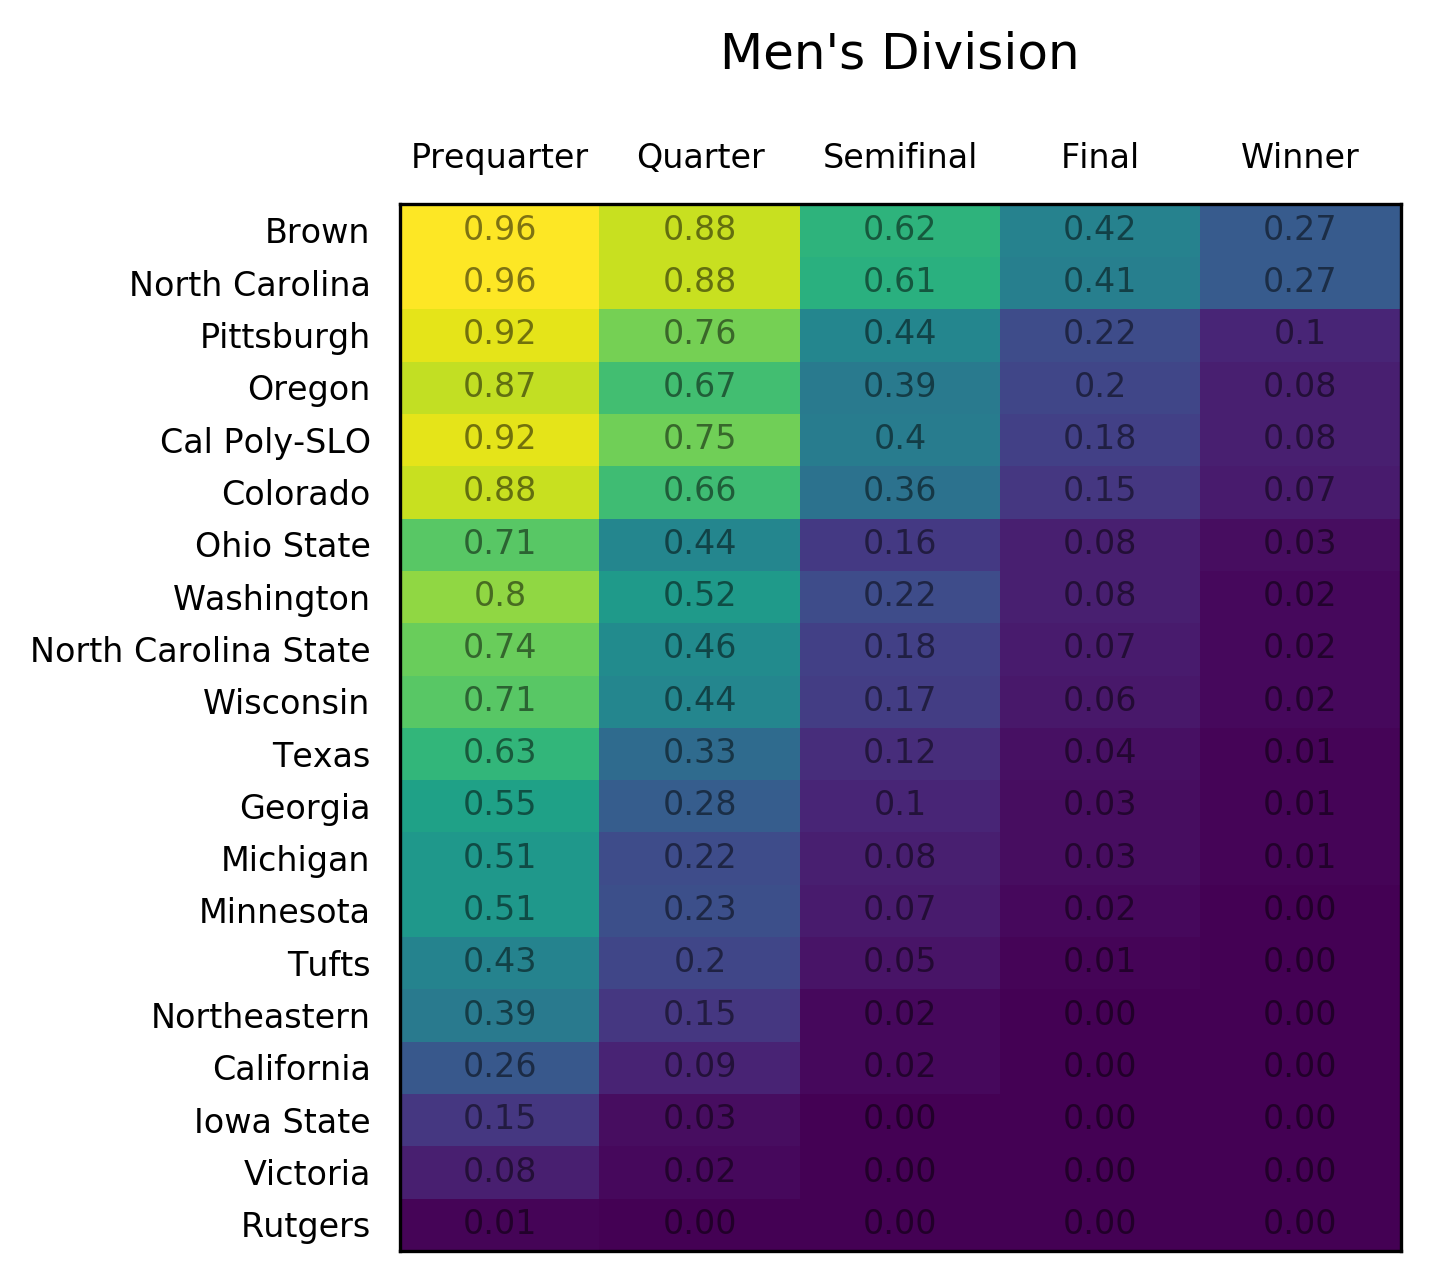

                         P     Q     S     F     W
Brown                 0.96  0.88  0.62  0.42  0.27
North Carolina        0.96  0.88  0.61  0.41  0.27
Pittsburgh            0.92  0.76  0.44  0.22  0.10
Oregon                0.87  0.67  0.39  0.20  0.08
Cal Poly-SLO          0.92  0.75  0.40  0.18  0.08
Colorado              0.88  0.66  0.36  0.15  0.07
Ohio State            0.71  0.44  0.16  0.08  0.03
Washington            0.80  0.52  0.22  0.08  0.02
North Carolina State  0.74  0.46  0.18  0.07  0.02
Wisconsin             0.71  0.44  0.17  0.06  0.02
Texas                 0.63  0.33  0.12  0.04  0.01
Georgia               0.55  0.28  0.10  0.03  0.01
Michigan              0.51  0.22  0.08  0.03  0.01
Minnesota             0.51  0.23  0.07  0.02  0.00
Tufts                 0.43  0.20  0.05  0.01  0.00
Northeastern          0.39  0.15  0.02  0.00  0.00
California            0.26  0.09  0.02  0.00  0.00
Iowa State            0.15  0.03  0.00  0.00  0.00
Victoria              0.08  0.0

In [1070]:
plot_advancement_likelihood_table(mens_teams, mens_team_colors, mens_outcome_counts, division='Men\'s')

In [870]:
def plot_advancement_likelihood(teams, team_colors, outcome_counts, division='(INSERT DIVISION)'):
    
    level_order = ('P','Q','S','F','W')
    
    num_tournaments = np.sum(outcome_counts['HighLevel'][teams[0]])
    
    plt.figure(figsize=(12,8))
    fig.patch.set_facecolor('white')
    for team in teams:
        x, y = [], []
        for i, level in enumerate(level_order):
            levels_at_this_point_or_higher = level_order[i:]
            x.append(i)
            total = 0
            for lev in levels_at_this_point_or_higher:
                try:
                    total += outcome_counts['HighLevel'][team].loc[lev]
                except:
                    total += 0
            y.append(total*1./num_tournaments)
        plt.plot(x, y, '-', color=team_colors[team], label=team, linewidth=3)
    plt.xticks(range(len(level_order)), labels=[level_dict[level] for level in level_order], rotation=0)
    plt.gca().tick_params(axis='y', right=True)
    plt.legend(loc='upper right', ncol=2, fontsize=10)
    plt.title(f'Chance of Advancing to Round \n({division} Division)')
    plt.ylabel('Probability')
    #plt.ylim([0, 1])
    #plt.xlim([0, 4])
    plt.tight_layout()
    plt.show()

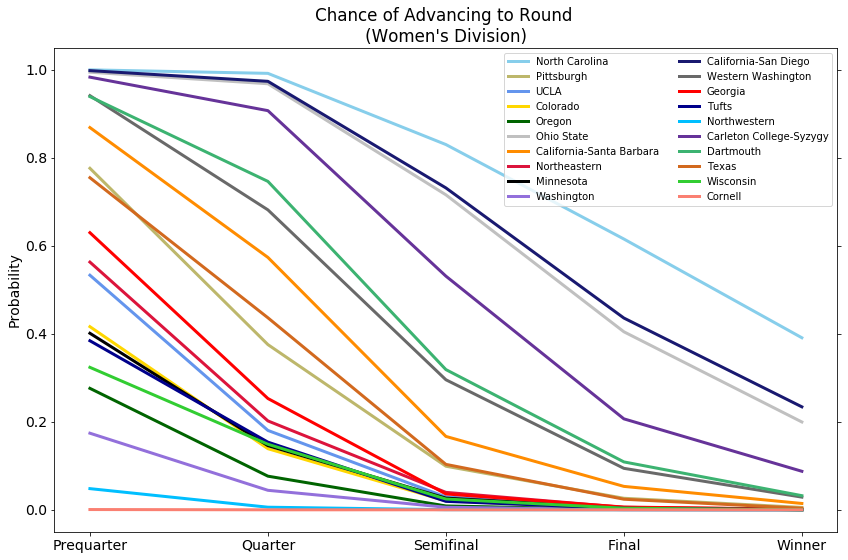

In [887]:
plot_advancement_likelihood(womens_teams, womens_team_colors, womens_outcome_counts, division='Women\'s')

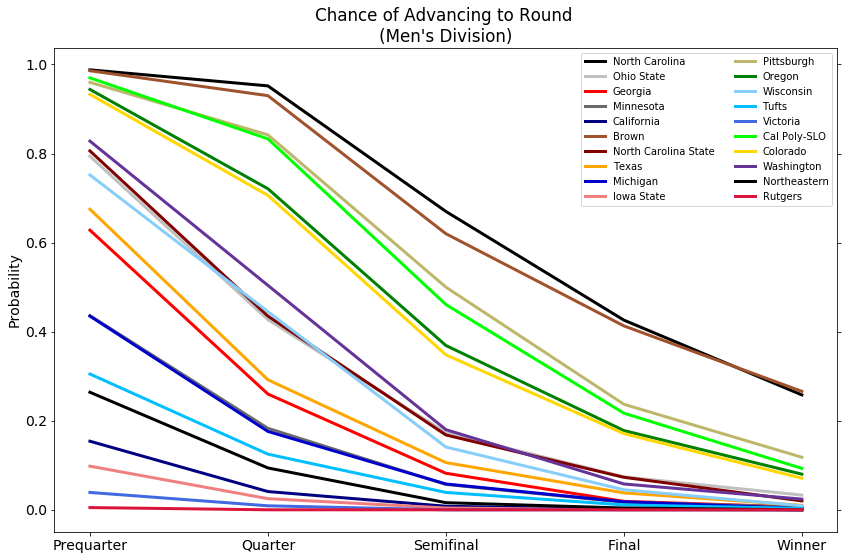

In [872]:
plot_advancement_likelihood(mens_teams, mens_team_colors, mens_outcome_counts, division='Men\'s')

In [869]:
def plot_highlevel_likelihood(teams, team_colors, outcome_counts, division='(INSERT DIVISION)'):
    
    level_order = ('PP','P','Q','S','F','W')
    
    num_tournaments = np.sum(outcome_counts['HighLevel'][teams[0]])
    
    plt.figure(figsize=(12,8))
    fig.patch.set_facecolor('white')
    for team in teams:
        x, y = [], []
        for i, level in enumerate(level_order):
            x.append(i)
            try:
                y.append(outcome_counts['HighLevel'][team].loc[level]*1./num_tournaments)
            except:
                y.append(0)
        plt.plot(x, y, '-', color=team_colors[team], label=team)
    plt.xticks(range(len(level_order)), labels=[level_dict[level] for level in level_order], rotation=0)
    plt.legend(loc='upper right', ncol=4, fontsize=10)
    plt.title(f'Chance of Highest Round Reached\n({division} Division)')
    plt.ylabel('Probability')
    plt.tight_layout()
    plt.show()

In [729]:
def reverse_cdf_plot_points_dist(teams, team_colors, outcome_counts, \
                                 mean_results_grouped_by_team, full_ymax_teams=[],\
                                 division='(INSERT DIVISION)'):
    
    print('WARNING: something fishy here, not sure why.')
    
    """
    Plot CDF of points outcomes for each team 
    
    Returns nothing
    """ 
    xlim_left = -0.5
    xlim_right = 30
    fig = plt.figure(figsize=(14,10))
    fig.patch.set_facecolor('white')
    plt.plot([xlim_left, xlim_right], [1,1], '-', color='gray', linewidth=0.5)
    for i, team in enumerate(teams):
        #plt.subplot(5,4,4*np.mod(i,5)+1 + np.floor(i/5.))
        
        # Calculate and plot CDF
        x = outcome_counts['Points'][team].sort_index().index.values
        y = outcome_counts['Points'][team].sort_index().values/sum(outcome_counts['Points'][team].values)
        plt.plot(x, 1-y.cumsum(), '-', color=team_colors[team], label=team, linewidth=2)
        plt.xlim(right=xlim_right)
        plt.ylabel('Probability')
        plt.xlabel('Points')
        plt.title(f'How likely is each team\'s fantasy score to exceed x?\n({division} Division)')
    plt.plot([xlim_left, xlim_right], [1,1], '-', color='gray', linewidth=0.5)
    plt.xlim([xlim_left, xlim_right])
    plt.ylim([0, 1.0])
    plt.legend(loc='upper right', ncol=1)
    plt.tight_layout()
    plt.show()

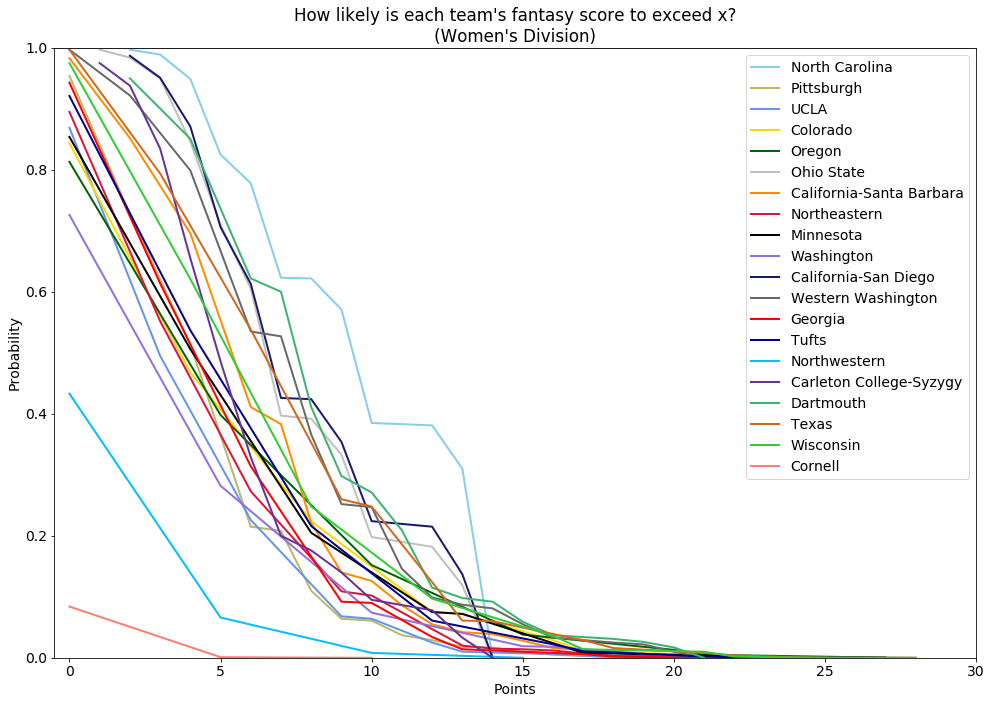

In [730]:
reverse_cdf_plot_points_dist(womens_teams, womens_team_colors, womens_outcome_counts, \
                             womens_mean_results_grouped_by_team, division='Women\'s')

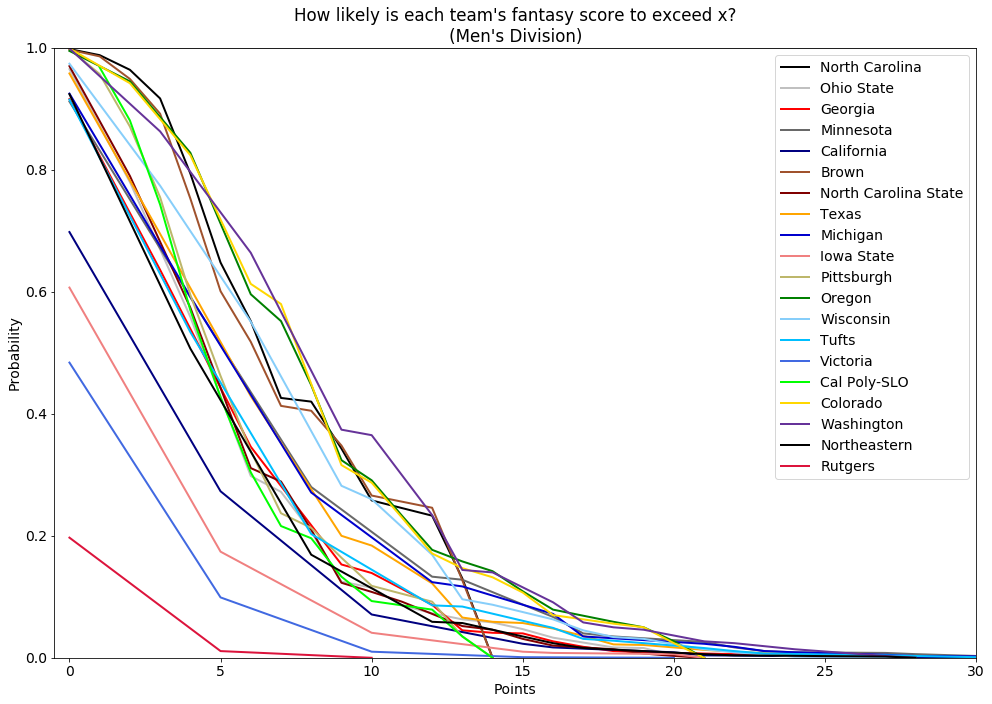

In [731]:
reverse_cdf_plot_points_dist(mens_teams, mens_team_colors, mens_outcome_counts, \
                             mens_mean_results_grouped_by_team, division='Men\'s')

In [555]:
# BIG QUESTION: What the expected high value overall of all teams of a given tournament?  
# i.e. What is the typical score needed to win?

mens_tournament_group_by_tournament_agg_max = mens_tournament_results.groupby('TournamentID').agg(max)

In [557]:
mens_tournament_group_by_tournament_agg_max

,TeamID,Pool,Rank,Seed,Team,PoolPlayPoints,PoolPlayWins,PoolPlayLosses,Wins,Losses,Points,MadeBracket,HighLevel
TournamentID,,,,,,,,,,,,,
0,19,D,5,5,Wisconsin,12.0,4.0,4.0,6.0,4.0,18.0,True,W
1,19,D,5,5,Wisconsin,12.0,4.0,4.0,7.0,4.0,16.0,True,W
2,19,D,5,5,Wisconsin,12.0,3.0,4.0,6.0,4.0,21.0,True,W
3,19,D,5,5,Wisconsin,12.0,4.0,4.0,6.0,4.0,16.0,True,W
4,19,D,5,5,Wisconsin,15.0,4.0,4.0,6.0,4.0,24.0,True,W
5,19,D,5,5,Wisconsin,9.0,4.0,4.0,7.0,4.0,20.0,True,W
6,19,D,5,5,Wisconsin,13.0,4.0,4.0,7.0,4.0,27.0,True,W
7,19,D,5,5,Wisconsin,13.0,4.0,4.0,6.0,4.0,18.0,True,W
8,19,D,5,5,Wisconsin,17.0,4.0,4.0,7.0,4.0,22.0,True,W


17.87


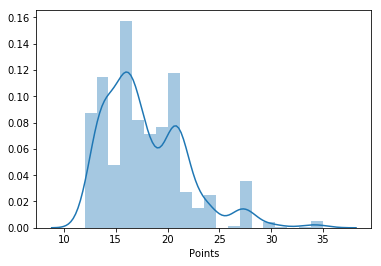

In [558]:
plt.figure()
sns.distplot(mens_tournament_group_by_tournament_agg_max['Points'])
print(np.mean(mens_tournament_group_by_tournament_agg_max['Points']))
plt.show()

In [559]:
def bar_plot_points_dist(teams, outcome_counts, mean_results_grouped_by_team, full_ymax_teams=[]):
    """
    Plot frequencies of each points outcome for each team as a bar graph.
    
    Returns nothing
    """ 
    fig = plt.figure(figsize=(10,10))
    fig.patch.set_facecolor('white')
    for i, team in enumerate(teams):
        plt.subplot(5,4,4*np.mod(i,5)+1 + np.floor(i/5.))
        plt.bar(outcome_counts['Points'][team].index.values, outcome_counts['Points'][team].values/sum(outcome_counts['Points'][team].values), width=1)
        if 4*np.mod(i,5)+1 + np.floor(i/5.) <= 12:
            plt.text(20., 0.2, 'mean:\n%0.2f' %mean_results_grouped_by_team[['Points']].loc[team])
        else:
            plt.text(20., 0.2, 'mean:\n%0.2f' %mean_results_grouped_by_team[['Points']].loc[team])
            plt.xlim(right=45)
        plt.xlim(left=-1, right=30)
        plt.ylim(top=0.5)
        if team in full_ymax_teams:
            plt.ylim(top=1.0)
        plt.ylabel('Frequency')
        plt.xlabel('Points')
        plt.title(team)
    plt.tight_layout()
    plt.show()

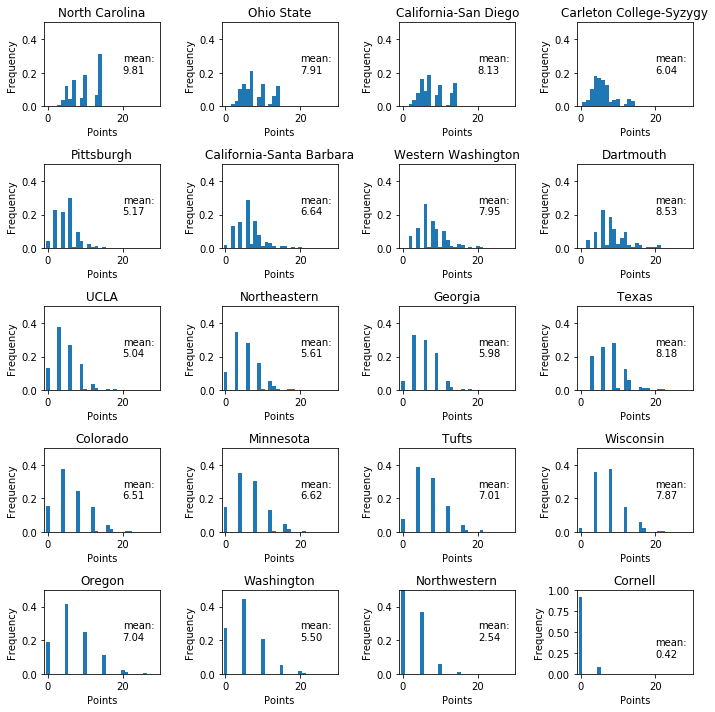

In [560]:
# Plot women's points distributions
bar_plot_points_dist(womens_teams, womens_outcome_counts, womens_mean_results_grouped_by_team, \
                     full_ymax_teams=['Cornell'])

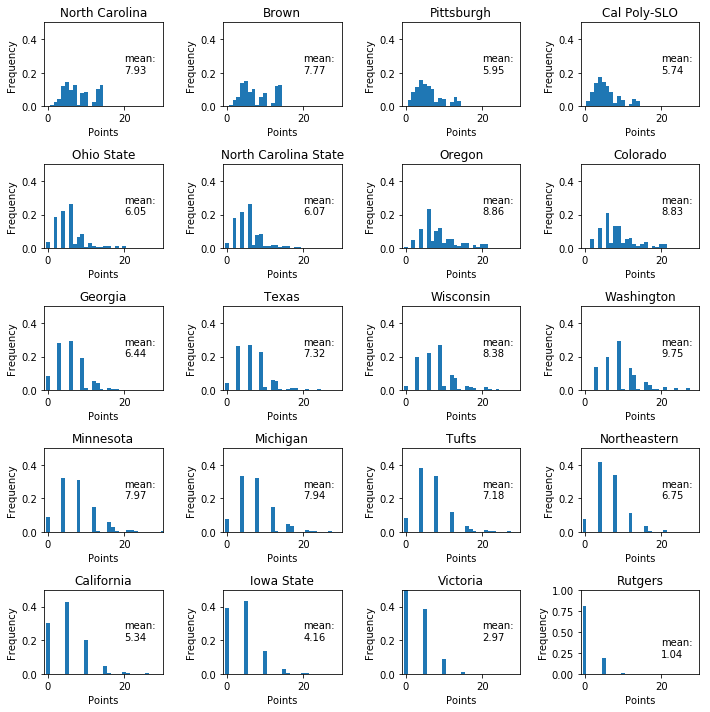

In [561]:
# Plot men's points distributions
bar_plot_points_dist(mens_teams, mens_outcome_counts, mens_mean_results_grouped_by_team, full_ymax_teams=['Rutgers'])

In [562]:
def bar_plot_poolplaywins_dist(teams, outcome_counts, mean_results_grouped_by_team, ymax=0.6):
    """
    Plot frequencies of each Wins outcome for each team.
    """
    fig = plt.figure(figsize=(10,10))
    fig.patch.set_facecolor('white')
    plt.rcParams.update({'font.size': 10})
    for i, team in enumerate(teams):
        plt.subplot(5,4,4*np.mod(i,5)+1 + np.floor(i/5.))
        color_val = 1#int(np.floor(i/5.))
        color_here = colors[color_val]
        plt.bar(outcome_counts['PoolPlayWins'][team].index.values, \
                outcome_counts['PoolPlayWins'][team].values/sum(outcome_counts['PoolPlayWins'][team].values), \
                width=0.95, color=color_here)
        if 4*np.mod(i,5)+1 + np.floor(i/5.) <= 12:
            plt.text(-0.5, 0.55*ymax, 'mean:\n%0.2f' %mean_results_grouped_by_team[['PoolPlayWins']].loc[team])
        else:
            plt.text(3., 0.55*ymax, 'mean:\n%0.2f' %mean_results_grouped_by_team[['PoolPlayWins']].loc[team])
        plt.xlim((-1, 5))
        plt.ylim(top=ymax)
        plt.xticks(range(5))
        plt.ylabel('Frequency')
        plt.xlabel('Pool Play Wins')
        plt.title(team)
    plt.tight_layout()
    plt.show()

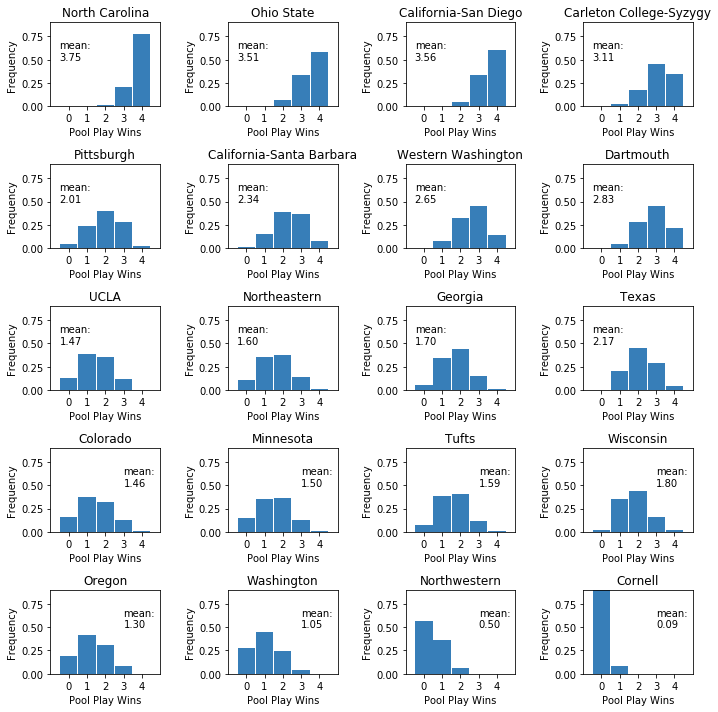

In [563]:
# Plot women's pool play wins distributions
bar_plot_poolplaywins_dist(womens_teams, womens_outcome_counts, womens_mean_results_grouped_by_team, ymax=0.9)

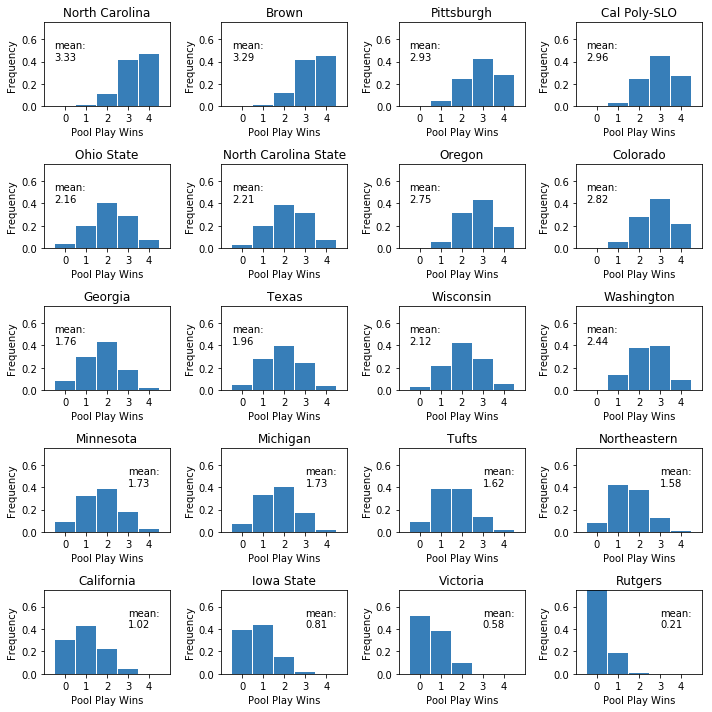

In [564]:
# Plot men's wins distributions
bar_plot_poolplaywins_dist(mens_teams, mens_outcome_counts, mens_mean_results_grouped_by_team, ymax=0.75)

In [568]:
def line_plot_poolplaywins_dist(teams, outcome_counts, team_ratings, team_colors, legend_font_size=10, division=''):
    """
    Plot frequencies of each Wins outcome for each team.
    """
    plt.figure(figsize=(11.5,8))
    for i, team in enumerate(teams):
        wins_here = outcome_counts['PoolPlayWins'][team].sort_index().index.values
        freq_here = outcome_counts['PoolPlayWins'][team].sort_index().loc[list(wins_here)]/sum(outcome_counts['PoolPlayWins'][team].values)
        label_here = team#'%s (%i)' %(team, team_ratings.loc[team]['Power Rating'])
        plt.plot(wins_here, freq_here[wins_here], label=label_here, color=team_colors[team], linewidth=3)
    plt.xlim([-0.2, 4.2])
    plt.ylim(bottom=0, top=1.0)
    plt.xticks(range(5))
    plt.ylabel('Frequency')
    plt.xlabel('Wins')
    plt.title('Pool Play Wins Distribution for %s Division' %division, fontsize=20)
    plt.rcParams.update({'font.size': 14})
    plt.legend(loc='upper center', ncol=4, fontsize=legend_font_size)
    plt.tight_layout()
    plt.show()

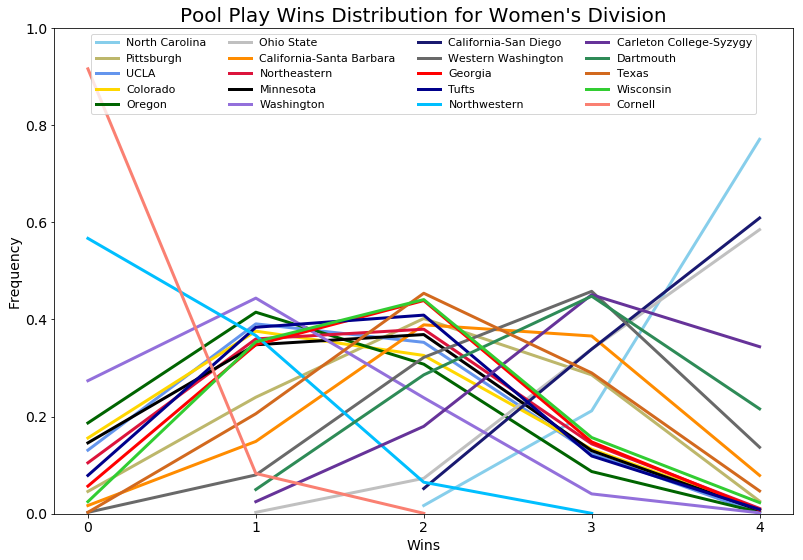

In [569]:
# Plot womens wins distributions
line_plot_poolplaywins_dist(womens_teams, womens_outcome_counts, womens_team_ratings, womens_team_colors,\
                    legend_font_size=11, division='Women\'s')

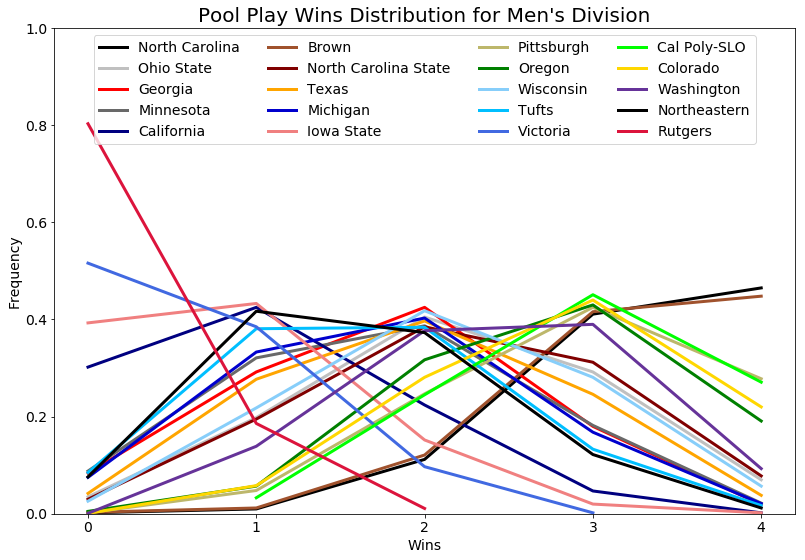

In [570]:
# Plot mens wins distributions
line_plot_poolplaywins_dist(mens_teams, mens_outcome_counts, mens_team_ratings, mens_team_colors,\
                    legend_font_size=14, division='Men\'s')